<a href="https://colab.research.google.com/github/kimhwijin/korean_food_classifier/blob/master/korean_food_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unzip Dataset

In [ ]:
import time

start = time.time()
!unzip -qq "drive/MyDrive/Datasets/kfood.zip"
end = time.time()
print((end-start) // 60, "분...")

4.0 분...


#Clone github

In [ ]:
!git clone https://github.com/kimhwijin/korean_food_classifier.git

Cloning into 'korean_food_classifier'...
remote: Enumerating objects: 445, done.
remote: Counting objects: 100% (445/445), done.
remote: Compressing objects: 100% (324/324), done.
remote: Total 445 (delta 263), reused 256 (delta 116), pack-reused 0
Receiving objects: 100% (445/445), 11.57 MiB | 23.64 MiB/s, done.
Resolving deltas: 100% (263/263), done.


In [ ]:
import sys
import os
sys.path.append(os.getcwd() + '/korean_food_classifier')

In [ ]:
import kfood_dataset

BATCH_SIZE = 32
RANDOMIZE = True #random crop variable
EPOCHS = 50
paths = kfood_dataset.get_image_paths()

dataset path : /content/kfood True
making class to label txt file...
saving classes, labels...
saving crop information...
ready!
finding image paths...
shuffling...
paths ready!


# Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split

# Make Train, Valid, Test, Dataset

In [ ]:
# train : 0.7, test : 0.2, valid : 0.1
train_paths_full, test_paths = train_test_split(paths, test_size=0.2)
train_paths, valid_paths = train_test_split(train_paths_full, test_size=0.125)

In [ ]:
train_set = kfood_dataset.make_kfood_dataset(train_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=BATCH_SIZE, shuffle_buffer_size=len(train_paths) // BATCH_SIZE, randomize=RANDOMIZE)
valid_set = kfood_dataset.make_kfood_dataset(valid_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=BATCH_SIZE, shuffle_buffer_size=len(valid_paths) // BATCH_SIZE, randomize=RANDOMIZE)
test_set = kfood_dataset.make_kfood_dataset(test_paths, n_parse_threads=tf.data.AUTOTUNE, batch_size=4, randomize=False)

# Plot samples

연근조림 보쌈 생선전 계란국 

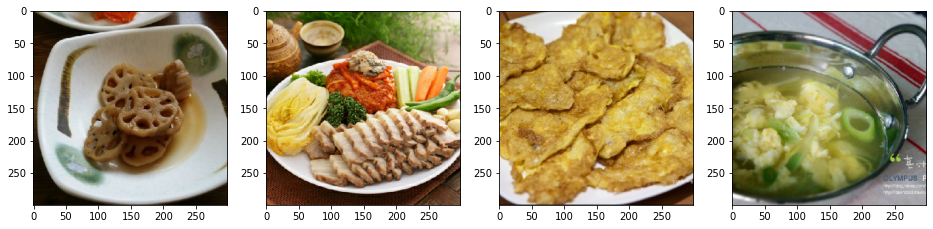

In [ ]:
kfood_dataset.plot_dataset_image_4(test_set)

# Train Properties

In [ ]:
from pathlib import Path
model_name = 'KerasInceptionResNetV2SEBlock'
weights_save_path = Path('drive/MyDrive/Model/kfood')
crop = 'random' if RANDOMIZE else 'central'
train_property = {
    'optimizer' : {
        'name': 'RMSprop',
        'lr_decay': 0.94,
        'kwargs': { 
            'learning_rate': 0.045,
            'rho': 0.9,
            'momentum': 0.0,
            'epsilon': 1 
        } 
    },
    'batch': str(BATCH_SIZE),
    'crop': crop,
}

In [ ]:
from train import train

model, history = train(train_set, valid_set, 
    steps_per_epoch=len(train_paths) // BATCH_SIZE,
    validation_steps=len(valid_paths) // BATCH_SIZE,
    epochs=EPOCHS,
    pretrained=False,
    save_best_weights=True, 
    save_weights_per_epoch=False, 
    weights_save_path=weights_save_path, 
    train_property=train_property,
    lr_schedule=True,
    model_name=model_name,
)
#pretrained epoch 11

Epoch 1/50
3292/3292 [==============================] - 2130s 627ms/step - loss: 3.2311 - accuracy: 0.2294 - val_loss: 3.0754 - val_accuracy: 0.2634 - lr: 0.0423
Epoch 2/50
3292/3292 [==============================] - 2062s 626ms/step - loss: 2.0057 - accuracy: 0.4685 - val_loss: 2.6148 - val_accuracy: 0.3781 - lr: 0.0423
Epoch 3/50
3292/3292 [==============================] - 2062s 626ms/step - loss: 1.5007 - accuracy: 0.5907 - val_loss: 1.8858 - val_accuracy: 0.5134 - lr: 0.0398
Epoch 4/50
3292/3292 [==============================] - 2060s 626ms/step - loss: 1.2615 - accuracy: 0.6482 - val_loss: 1.5265 - val_accuracy: 0.5900 - lr: 0.0398
Epoch 5/50
3292/3292 [==============================] - 2058s 625ms/step - loss: 1.0720 - accuracy: 0.6981 - val_loss: 1.5067 - val_accuracy: 0.6064 - lr: 0.0374
Epoch 6/50
3292/3292 [==============================] - 2058s 625ms/step - loss: 0.9721 - accuracy: 0.7236 - val_loss: 1.4407 - val_accuracy: 0.6134 - lr: 0.0374
Epoch 7/50
3292/3292 [======

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_set, steps=len(test_paths) // 4)

7525/7525 [==============================] - 258s 34ms/step - loss: 0.4183 - accuracy: 0.8979


[0.4183480441570282, 0.8979402184486389]

In [ ]:
from train import train

model, history = train(train_set, valid_set, 
    steps_per_epoch=len(train_paths) // BATCH_SIZE,
    validation_steps=len(valid_paths) // BATCH_SIZE,
    epochs=30,e
    pretrained=True,
    save_best_weights=True, 
    save_weights_per_epoch=False, 
    weights_save_path=weights_save_path, 
    train_property=train_property,
    model_name=model_name,
    lr_schedule=True,
)

Epoch 1/30
3292/3292 [==============================] - 1476s 435ms/step - loss: 0.5320 - accuracy: 0.8515 - val_loss: 0.4877 - val_accuracy: 0.8657 - lr: 0.0123
Epoch 2/30
3292/3292 [==============================] - 1430s 434ms/step - loss: 0.4866 - accuracy: 0.8630 - val_loss: 0.4447 - val_accuracy: 0.8765 - lr: 0.0123
Epoch 3/30
3292/3292 [==============================] - 1429s 434ms/step - loss: 0.4500 - accuracy: 0.8709 - val_loss: 0.4550 - val_accuracy: 0.8733 - lr: 0.0115
Epoch 4/30
3292/3292 [==============================] - 1429s 434ms/step - loss: 0.4151 - accuracy: 0.8799 - val_loss: 0.5058 - val_accuracy: 0.8590 - lr: 0.0115
Epoch 5/30
3292/3292 [==============================] - 1432s 435ms/step - loss: 0.3880 - accuracy: 0.8870 - val_loss: 0.4442 - val_accuracy: 0.8761 - lr: 0.0108
Epoch 6/30
3292/3292 [==============================] - 1430s 434ms/step - loss: 0.3735 - accuracy: 0.8910 - val_loss: 0.4711 - val_accuracy: 0.8690 - lr: 0.0108
Epoch 7/30
3292/3292 [======